# 0. Imports

In [1]:
import sys

sys.path.append("../src/")

import random
import shap
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import Lasso, LogisticRegression, Ridge
from sklearn.metrics import (
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.utils import shuffle
from tqdm import tqdm
from utils import mape, mean_std_cross_val_scores
from xgboost import XGBClassifier, XGBRegressor

random.seed(0)

# 1. Tags and Data Preparation

In [2]:
tags = pd.read_excel("../data/tags/tags.xlsx")

In [3]:
tags_dict = {}
for i in range(len(tags)):
    tags_dict[f"{tags.loc[i, 'Tags']}"] = tags.loc[i, 'Definition']

In [4]:
df = pd.read_csv("../data/processed/economic_dataset.csv")

In [5]:
df

,DATE,A091RC1Q027SBEA,A939RX0Q048SBEA,BOGMBASE,FEDFUNDS,FPCPITOTLZGUSA,FYFSGDA188S,GDPC1,GFDEGDQ188S,IMPGS,...,M2V,MEHOINUSA672N,PAYEMS,PCEC96,PPIACO,T10Y2Y,TOTRESNS,SP500_full,UNRATE,VIXCLS
0,1980-01-31,102.252,32377.0,156000.0,13.82,13.549202,-2.5839,7341.557,30.94982,304.311,...,1.869,56780.0,90800.0,11181.0,85.200,0.014615,45.2,110.90,6.3,23.347273
1,1980-02-29,102.252,32377.0,153900.0,14.13,13.549202,-2.5839,7341.557,30.94982,304.311,...,1.869,56780.0,90883.0,11181.0,86.900,0.014615,43.2,115.30,6.3,23.347273
2,1980-03-31,102.252,32377.0,155000.0,17.19,13.549202,-2.5839,7341.557,30.94982,304.311,...,1.869,56780.0,90994.0,11181.0,87.500,0.014615,43.1,104.70,6.3,23.347273
3,1980-04-30,107.264,31621.0,157900.0,17.61,13.549202,-2.5839,7190.289,31.37303,292.600,...,1.847,56780.0,90849.0,11181.0,87.800,0.014615,44.9,103.00,6.9,23.347273
4,1980-05-31,107.264,31621.0,157900.0,10.98,13.549202,-2.5839,7190.289,31.37303,292.600,...,1.847,56780.0,90420.0,11181.0,88.300,0.014615,44.0,107.70,7.5,23.347273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,2023-12-31,1025.796,67513.0,5827400.0,5.33,4.116338,-6.1903,22679.255,121.62069,3835.394,...,1.350,74580.0,157304.0,15655.8,249.866,-0.437000,3492.0,4685.05,3.7,12.718500
528,2024-01-31,1059.235,67672.0,5843700.0,5.33,4.116338,-6.1903,22758.752,122.34717,3919.689,...,1.361,74580.0,157560.0,15601.2,251.306,-0.264762,3507.0,4804.49,3.7,13.388636
529,2024-02-29,1059.235,67672.0,5896900.0,5.33,4.116338,-6.1903,22758.752,122.34717,3919.689,...,1.361,74580.0,157796.0,15638.3,254.926,-0.336500,3567.7,5011.96,3.9,13.980476
530,2024-03-31,1059.235,67672.0,5883000.0,5.33,4.116338,-6.1903,22758.752,122.34717,3919.689,...,1.361,74580.0,158106.0,15689.6,255.095,-0.379500,3543.1,5170.57,3.8,13.787500


In [6]:
df.drop(columns=["DATE"], inplace=True)

# 2. Train/Test Split

In [7]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
train_df.head()

,A091RC1Q027SBEA,A939RX0Q048SBEA,BOGMBASE,FEDFUNDS,FPCPITOTLZGUSA,FYFSGDA188S,GDPC1,GFDEGDQ188S,IMPGS,M2REAL,M2V,MEHOINUSA672N,PAYEMS,PCEC96,PPIACO,T10Y2Y,TOTRESNS,SP500_full,UNRATE,VIXCLS
402,416.742,56272.0,3290900.0,0.09,1.464833,-4.02694,17860.450,98.72797,2767.183,4602.1,1.573,65740.0,136391.0,11872.3,204.400,0.014615,2147.7,1668.68,7.3,13.974545
22,142.404,32095.0,167200.0,13.31,10.334715,-2.46233,7410.768,31.35587,319.445,1850.9,1.888,56780.0,91171.0,11181.0,98.800,0.014615,40.9,122.90,8.3,23.347273
516,873.800,66096.0,5329000.0,4.33,4.116338,-6.19030,22112.329,117.32269,3890.491,7065.9,1.271,74580.0,154773.0,15317.6,260.227,-0.676000,3029.9,3960.66,3.4,20.169048
436,453.291,58787.0,3836500.0,0.37,1.261583,-3.10903,19062.709,103.58005,2711.306,5327.9,1.466,70840.0,143901.0,12891.2,185.300,0.014615,2443.8,2065.55,4.8,14.852857
280,290.322,50796.0,713700.0,1.26,2.270095,-3.29583,14743.567,58.96101,1527.336,3258.2,1.901,65860.0,130196.0,11181.0,136.700,0.014615,41.8,935.96,6.1,20.239524


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 425 entries, 402 to 510
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   A091RC1Q027SBEA  425 non-null    float64
 1   A939RX0Q048SBEA  425 non-null    float64
 2   BOGMBASE         425 non-null    float64
 3   FEDFUNDS         425 non-null    float64
 4   FPCPITOTLZGUSA   425 non-null    float64
 5   FYFSGDA188S      425 non-null    float64
 6   GDPC1            425 non-null    float64
 7   GFDEGDQ188S      425 non-null    float64
 8   IMPGS            425 non-null    float64
 9   M2REAL           425 non-null    float64
 10  M2V              425 non-null    float64
 11  MEHOINUSA672N    425 non-null    float64
 12  PAYEMS           425 non-null    float64
 13  PCEC96           425 non-null    float64
 14  PPIACO           425 non-null    float64
 15  T10Y2Y           425 non-null    float64
 16  TOTRESNS         425 non-null    float64
 17  SP500_full    

In [9]:
X_train = train_df.drop(columns=["SP500_full"])
y_train = train_df["SP500_full"]

X_test = test_df.drop(columns=["SP500_full"])
y_test = test_df["SP500_full"]

# 3. Preparation of Preprocessors

In [10]:
preprocessor = StandardScaler()

# 4. Cross-Validation of ML Models

In [11]:
results = {}

In [12]:
mape_scorer = make_scorer(mape, greater_is_better=False)

## 4.1. Baseline Model

In [13]:
pipe_dummy = make_pipeline(preprocessor, DummyRegressor())

In [14]:
results["Dummy"] = mean_std_cross_val_scores(
    pipe_dummy,
    X_train,
    y_train,
    return_train_score=True,
    scoring="neg_mean_squared_error",
)

In [15]:
pd.DataFrame(results)

,Dummy
fit_time,0.003 (+/- 0.001)
score_time,0.002 (+/- 0.001)
test_score,-1404809.714 (+/- 198698.575)
train_score,-1400085.409 (+/- 50520.456)


## 4.2. ML Models

In [16]:
random_state = 123

pipe_ridge = make_pipeline(
    preprocessor, Ridge(max_iter=2000, random_state=random_state)
)
pipe_lasso = make_pipeline(
    preprocessor, Lasso(max_iter=2000, random_state=random_state)
)
pipe_rf = make_pipeline(preprocessor, RandomForestRegressor(random_state=random_state))
pipe_xgb = make_pipeline(
    preprocessor, XGBRegressor(random_state=random_state, verbosity=0)
)
pipe_lgbm = make_pipeline(preprocessor, LGBMRegressor(random_state=random_state))
pipe_catb = make_pipeline(
    preprocessor,
    CatBoostRegressor(random_state=random_state, verbose=0, loss_function="RMSE"),
)

In [17]:
models = {
    "ridge": pipe_ridge,
    "lass": pipe_lasso,
    "random_forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catb,
}

In [18]:
for name, model in tqdm(models.items()):
    results[name] = mean_std_cross_val_scores(
        model,
        X_train,
        y_train,
        return_train_score=True,
        scoring="neg_mean_squared_error",
    )

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:13<00:00,  2.26s/it]


In [19]:
pd.DataFrame(results)

,Dummy,ridge,lass,random_forest,XGBoost,LightGBM,CatBoost
fit_time,0.003 (+/- 0.001),0.006 (+/- 0.003),0.007 (+/- 0.002),0.450 (+/- 0.013),0.082 (+/- 0.016),0.031 (+/- 0.003),2.072 (+/- 0.151)
score_time,0.002 (+/- 0.001),0.002 (+/- 0.001),0.002 (+/- 0.001),0.010 (+/- 0.001),0.006 (+/- 0.002),0.003 (+/- 0.001),0.003 (+/- 0.000)
test_score,-1404809.714 (+/- 198698.575),-13488.554 (+/- 2743.486),-13395.956 (+/- 2668.206),-5975.290 (+/- 3020.842),-6996.500 (+/- 5612.660),-8096.864 (+/- 4836.461),-2383.798 (+/- 1080.474)
train_score,-1400085.409 (+/- 50520.456),-11784.223 (+/- 685.258),-11845.617 (+/- 678.939),-646.010 (+/- 32.878),-0.759 (+/- 0.266),-2272.988 (+/- 471.958),-126.561 (+/- 15.281)


# 5. Evaluation of `Ridge` Model

In [20]:
pipe_ridge.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(max_iter=2000, random_state=123))])

## 5.1. Comparison between Prediction and `y_test`

In [21]:
y_pred = pipe_ridge.predict(X_test)

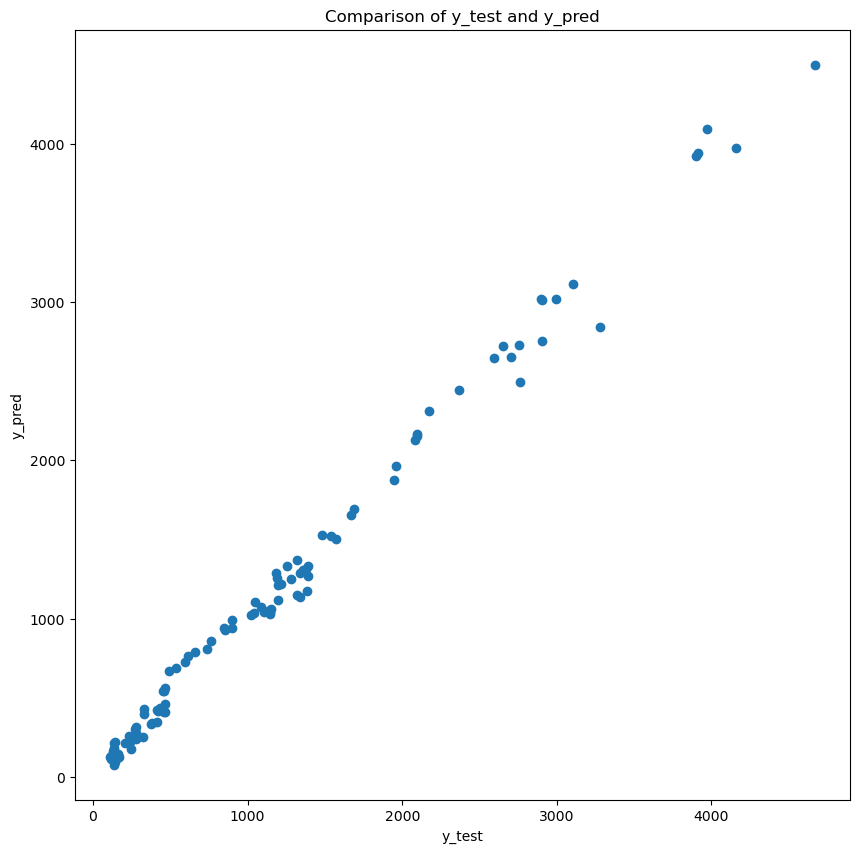

In [22]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.title("Comparison of y_test and y_pred")
plt.show();

In [23]:
mape(y_test, y_pred)

10.464148400485028

## 5.2. Feature Importance

In [24]:
features = []
for col in list(X_train.columns):
    features.append(tags_dict[col])

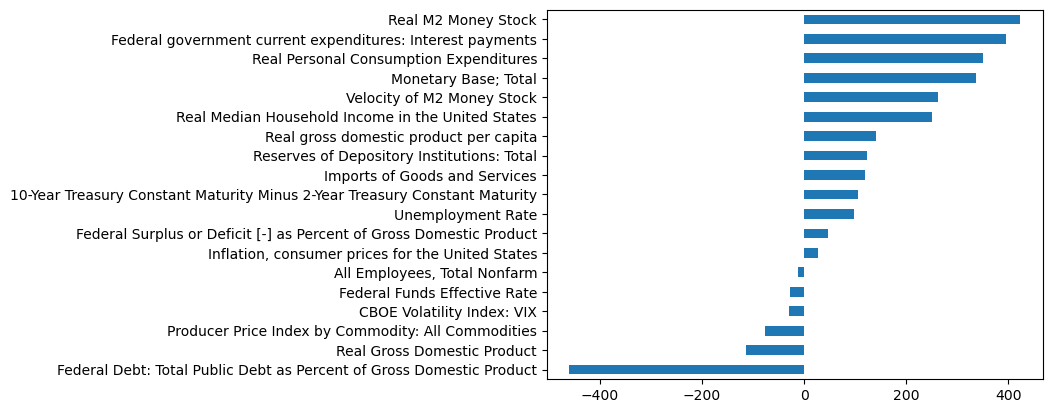

In [25]:
# Top 20 Features
top20_ridge = pd.Series(
    pipe_ridge.named_steps["ridge"].coef_.flatten(), 
    features
).sort_values(ascending=False)#.head(20)

top20_ridge.plot.barh().invert_yaxis()
plt.show();

# 6. Evaluation of `CatBoost` Model

In [26]:
pipe_catb.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x0000016CA1D98220>)])

In [27]:
shap.initjs()

In [28]:
catboost_explainer = shap.Explainer(pipe_catb.named_steps["catboostregressor"])

In [29]:
X_test_enc = pd.DataFrame(
    pipe_catb.named_steps["standardscaler"].transform(X_test),
    columns=features,
    index=X_test.index
)

In [30]:
shap_values = catboost_explainer(X_test_enc)

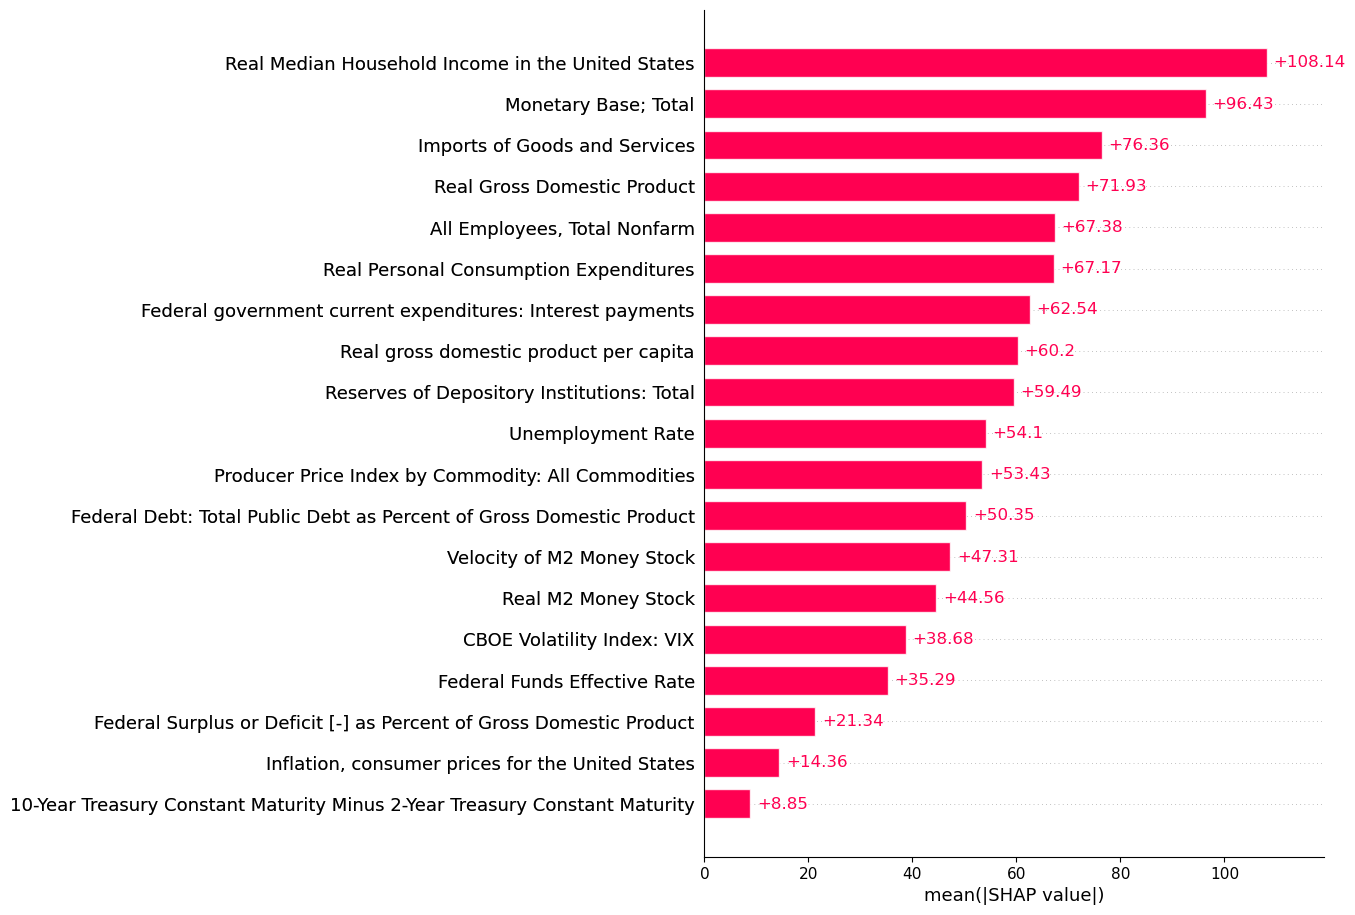

In [31]:
shap.plots.bar(shap_values, max_display=20)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


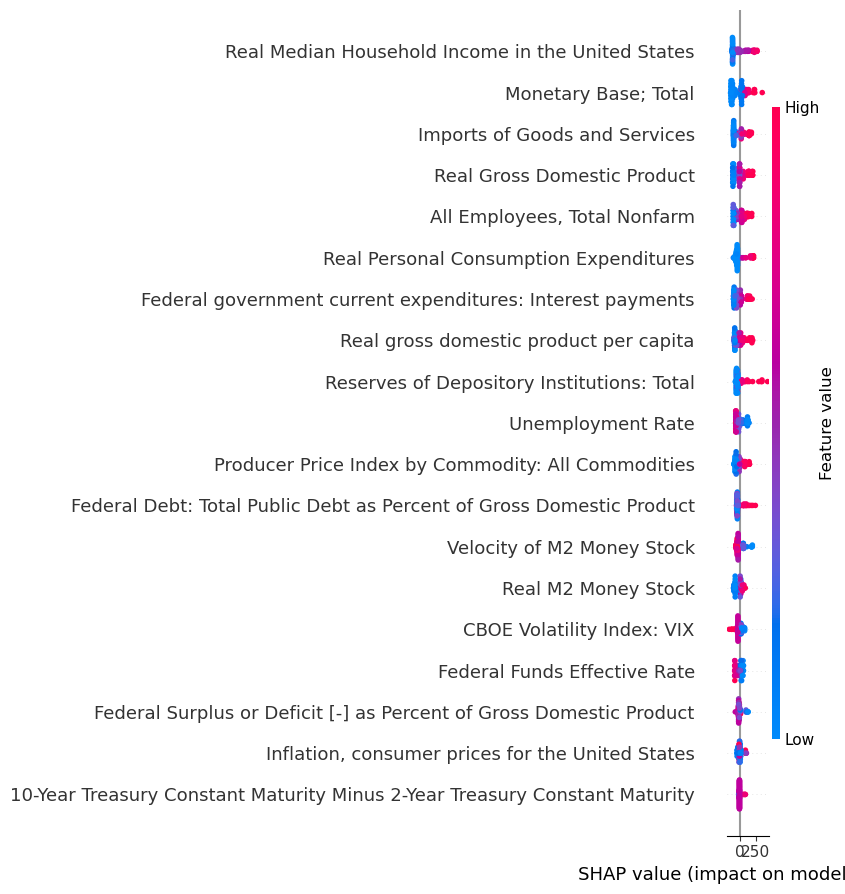

In [32]:
shap.summary_plot(shap_values)